In [1]:
%pip install wandb
%pip install graphviz
%pip install torchviz
import wandb
wandb.login()#doesnt detect WANDB_NOTEBOOK_NAME on windows

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tetetoutou (simclr-doctoral-research). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="test-project", entity="simclr-doctoral-research")

In [3]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 512
}

In [4]:
import os
import wandb
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 10
batch_size = 512
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset_train = MNIST('./data', transform=img_transform, download=True,train = True)
dataset_test = MNIST('./data', transform=img_transform, download=True,train = False)

dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128))
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256,28 * 28), 
            nn.Tanh())
    def forward(self, x,only_encode=False):
        if only_encode:
            return self.encoder(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)#this line is needed
#to freeze gradients

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
    wandb.log({"loss": loss})

    wandb.watch(model)
    #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))

pic = to_img(output.cpu().data)
save_image(pic, './mlp_img/image_final.png')


cuda
epoch [1/10], loss:0.0977
epoch [2/10], loss:0.0566
epoch [3/10], loss:0.0458
epoch [4/10], loss:0.0391
epoch [5/10], loss:0.0307
epoch [6/10], loss:0.0318
epoch [7/10], loss:0.0249
epoch [8/10], loss:0.0232
epoch [9/10], loss:0.0216
epoch [10/10], loss:0.0205


In [6]:
#test of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = model(img)
    pic = to_img(output.cpu().data)
    save_image(pic, './mlp_img/image_test.png')
#accuracy of the autoencoder comparing input and output
loss_sum = 0
for data in test_data:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    output = model(img)
    loss = criterion(output, img)
    loss_sum += loss.item()

print(loss_sum/len(test_data))


0.02110848082229495


In [7]:
from torchviz import make_dot
y = model(img)
make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")

'torchviz.png'

Now the encoder is going to be frozen

In [8]:
#freeze the encoder
# print(model.state_dict())

model.encoder[0].weight.requires_grad = False
model.encoder[0].bias.requires_grad = False
model.encoder[2].weight.requires_grad = False
model.encoder[2].bias.requires_grad = False


for name, param in model.named_parameters():
    print(name, param.requires_grad)



# if param.requires_grad:print(name)
# for param in model.parameters():
#     print(param)
#     param.requires_grad = False


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True


In [9]:
#save the encoder
os.makedirs('./saved_models', exist_ok=True)
torch.save(model.state_dict(), './saved_models/autoencoder.pth')

In [10]:
class linear_classifier(nn.Module):
    def __init__(self):
        super(linear_classifier, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        

In [11]:
#load the encoder
model.load_state_dict(torch.load('./saved_models/autoencoder.pth'))
#add a mlp to the encoder
model.add_module('linear_classifier', linear_classifier())



In [12]:
#joined model
class joined_model(nn.Module):
    def __init__(self):
        super(joined_model, self).__init__()
        self.encoder = autoencoder().encoder
        self.classifier = linear_classifier()
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
joined_model = joined_model().to(device)

In [13]:
joined_model.encoder[0].weight.requires_grad = False
joined_model.encoder[0].bias.requires_grad = False
joined_model.encoder[2].weight.requires_grad = False
joined_model.encoder[2].bias.requires_grad = False

In [14]:
#verify weight are frozen

for name, param in joined_model.named_parameters():
    print(name, param.requires_grad)
print(model.parameters)


encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
classifier.fc1.weight True
classifier.fc1.bias True
classifier.fc2.weight True
classifier.fc2.bias True
<bound method Module.parameters of autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
  (linear_classifier): linear_classifier(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)>


In [15]:
#train the model on the labeled data
# model = model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, joined_model.parameters()), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    for data in dataloader:
        img, label = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        label = Variable(label).to(device)
        # ===================forward=====================
        output = joined_model(img)#This should only use the encoder
        loss = criterion(output, label)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.item()))
    wandb.log({"loss": loss})
    wandb.watch(joined_model)

epoch [1/10], loss:0.8198
epoch [2/10], loss:0.6517
epoch [3/10], loss:0.5391
epoch [4/10], loss:0.4986
epoch [5/10], loss:0.4623
epoch [6/10], loss:0.4367
epoch [7/10], loss:0.3694
epoch [8/10], loss:0.4560
epoch [9/10], loss:0.3728
epoch [10/10], loss:0.3867


In [16]:
#evaluate the model
loss_sum = 0
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    label = Variable(label).to(device)
    output = joined_model(img)
    loss = criterion(output, label)
    loss_sum += loss.item()


print(loss_sum/len(test_data))


0.3817852199077606


In [ ]:
#

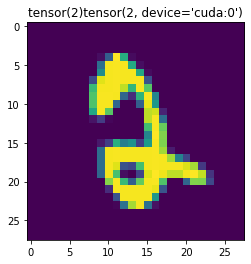

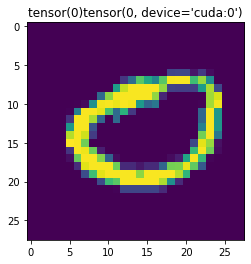

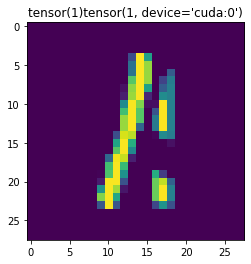

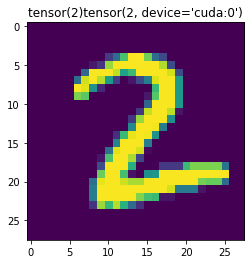

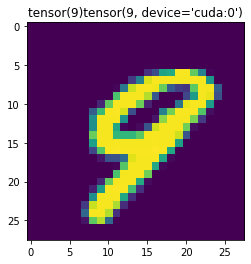

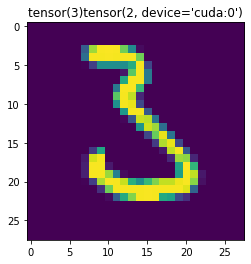

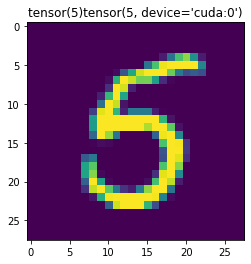

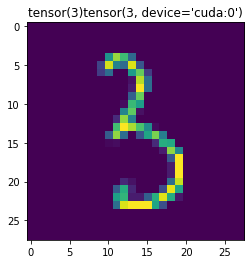

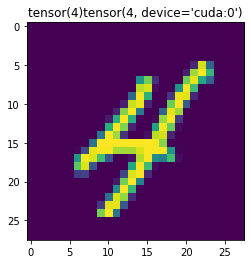

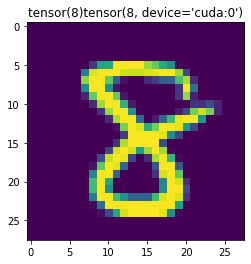

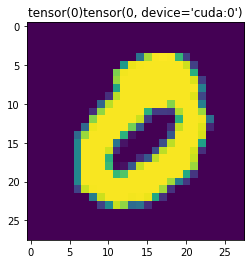

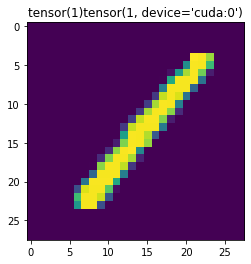

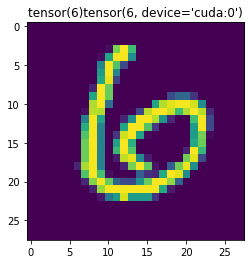

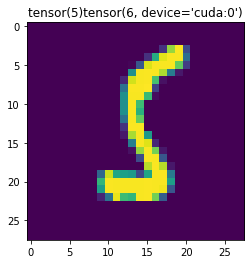

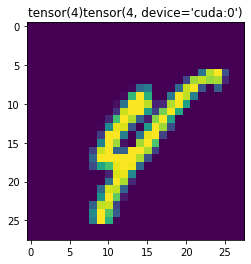

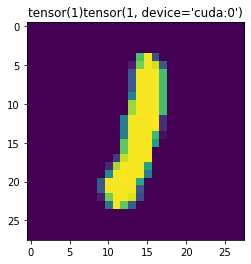

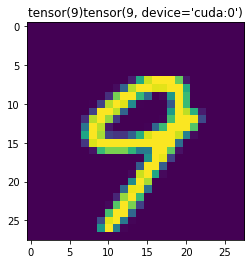

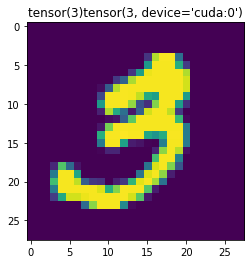

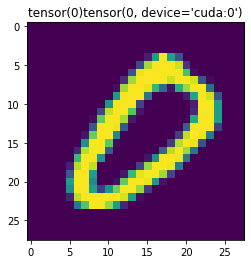

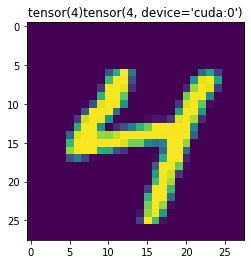

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# from fastai.vision.all import show_image
#show results of the model
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
for data in test_data:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    #label = Variable(label).to(device)
    output = joined_model(img)
    pic = to_img(img.cpu().data)
    # save_image(pic, './mlp_img/image_test.png')
    #show predicted label for the image
    #print(output.argmax(dim=1))
    #show the true label for the image
    #print(label)
    #show the image
    plt.imshow(np.transpose(img.view(img.size(0), 1, 28, 28).cpu().data[0], (1,2, 0)))
    #show the label corresponding to the image
    plt.title(str(label[0])+str(output.argmax(dim=1)[0]))
    plt.show()
    plt.close()

    

In [18]:
#save the joined_model
torch.save(joined_model.state_dict(), './saved_models/joined_model.pth')
